<a href="https://colab.research.google.com/github/Val2425/MachineLearningProject-Korea2024/blob/main/MachineLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**


**Purpose:**

This project aims to classify news articles as real or fake using machine learning on textual content alone. Through natural language processing (NLP), we seek to detect misleading information—a crucial skill in today’s digital world.

-

**What is the Problem?**

The rapid spread of fake news, especially via social media, poses significant risks to public opinion and social trust. This project focuses on distinguishing real from fake news articles, an issue highlighted by events like the American elections, where misinformation can heavily influence public sentiment.

-

**Why is This Problem Important?**

Detecting fake news is both a timely and complex challenge. This project is intellectually engaging as it leverages NLP for a socially relevant task while remaining manageable within a binary classification framework.

-

**Expected Outcomes of the Model**

Our objective is to develop a model with an F1-score of at least 0.85, balancing precision and recall to effectively minimize misclassifications. This metric underscores the model’s aim to accurately identify fake news while reducing errors, aligning with the critical nature of the task.

# **2. Methods**

## **2.1 Import dataset from Kaggle**

We decided to use the "Fake News Detection" datataset ([Link to the dataset](https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection))

First we download our personal kaggle API key on our computer. Then we add it the the google colab files :

In [2]:
from google.colab import files
uploaded = files.upload()
del uploaded

Saving kaggle.json to kaggle.json


We then create a kaggle folder and copy kaggle.json to the folder created and give permission for the json to act

In [3]:
#create folder
!mkdir ~/.kaggle

#copy kaggle.json to folder
!cp kaggle.json ~/.kaggle/

#permission
! chmod 600 ~/.kaggle/kaggle.json

We then paste to code given when we click on the download button for the dataset on the kaggle website

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/fake-news-detection")

print("Path to dataset files:", path)

100%|██████████| 41.0M/41.0M [00:00<00:00, 86.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhavikjikadara/fake-news-detection/versions/1


Then change directory to be in the file with the two files

In [5]:
cd /root/.cache/kagglehub/datasets/bhavikjikadara/fake-news-detection/versions/1

/root/.cache/kagglehub/datasets/bhavikjikadara/fake-news-detection/versions/1


##**2.2 Dataset Description**

Description of the dataset

## **2.3 Data Preprocessing**

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

true_df = pd.read_csv('true.csv')
fake_df = pd.read_csv('fake.csv')

### **2.3.1 Data correction**

Some dates from fake.csv contain month that are written with three letters (ex : Nov, Jan, etc.). So we correct it and convert dates to Date variables.

In [7]:
# Replacing abbreviation to have a uniform format for dates
mois = {
    'Jan ': 'January ',
    'Feb ': 'February ',
    'Mar ': 'March ',
    'Apr ': 'April ',
    'May ': 'May ',
    'Jun ': 'June ',
    'Jul ': 'July ',
    'Aug ': 'August ',
    'Sep ': 'September ',
    'Oct ': 'October ',
    'Nov ': 'November ',
    'Dec ': 'December '
}
fake_df['date'] = fake_df['date'].replace(mois, regex=True)

In [8]:
# Converting dates to Date variables
true_df['date'] = pd.to_datetime(true_df['date'], errors='coerce')
fake_df['date'] = pd.to_datetime(fake_df['date'], errors='coerce')

We can see that true_df text column contains "(Reuters) - " that can cause overfitting. So we have to delete it.

In [9]:
# Delete all text until "(Reuters) - " in true_df
true_df['text'] = true_df['text'].str.replace(r'^.*\(Reuters\) - ', '', regex=True)

After conversion and replacement of the abbreviation, we find 45 null values in fake_df. 45 is a low number so we will just erase them.

We also erase duplicates

In [10]:
# Erase null values in fake_df
fake_df.dropna(inplace=True)

# Erase duplicates
true_df.drop_duplicates(keep='first', inplace=True)
fake_df.drop_duplicates(keep='first', inplace=True)

### **2.3.2 Data cleaning**

Before cleaning the data, we decide to add a new column that counts the percentage of uppercase letters in the title. It seems to be a very relevant feature but we will remove it if the performance of the model without it is similar.

In [11]:
# Function to calculate the percentage of uppercase letters
def calculate_uppercase_percentage(text):
    if len(text) == 0:  # Avoid division by zero
        return 0
    uppercase_count = sum(1 for char in text if char.isupper())
    return (uppercase_count / len(text))*100

# Add the column with the calculated percentages
true_df['uppercase_percentage'] = true_df['title'].apply(calculate_uppercase_percentage)
fake_df['uppercase_percentage'] = fake_df['title'].apply(calculate_uppercase_percentage)

For simplicity of the model and because we will tokenize word by word, we will choose to remove all the punctuation and the special characters.

In [12]:
import re

# Remove special characters
true_df['title'] = true_df['title'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
true_df['text'] = true_df['text'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

fake_df['title'] = fake_df['title'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
fake_df['text'] = fake_df['text'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

We then remove the uppercase letters and extra spaces

In [13]:
# Convert all to lowercase
true_df['title'] = true_df['title'].str.lower()
true_df['text'] = true_df['text'].str.lower()
fake_df['title'] = fake_df['title'].str.lower()
fake_df['text'] = fake_df['text'].str.lower()

# Remove extra spaces
true_df['title'] = true_df['title'].str.strip()
true_df['text'] = true_df['text'].str.strip()
fake_df['title'] = fake_df['title'].str.strip()
fake_df['text'] = fake_df['text'].str.strip()

###**2.3.3 The subject column**

The subject column is problematic because the true and fake news have different categories.

In [14]:
# List all unique subjects
print(true_df['subject'].unique())
print()
print(fake_df['subject'].unique())

['politicsNews' 'worldnews']

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


In [15]:
true_df['label'] = 1  # 1 for true news
fake_df['label'] = 0  # 0 for fake news

We can try to normalize the subject

In [16]:
subject_mapping = {
    'News': 'General News',
    'US_News': 'General News',
    'worldnews': 'General News',
    'politics': 'Politics',
    'politicsNews': 'Politics',
    'left-news': 'Politics',
    'Middle-east': 'General News',
    'Government News': 'Politics'
}
fake_df['subject'] = fake_df['subject'].map(subject_mapping)
true_df['subject'] = true_df['subject'].map(subject_mapping)


In [17]:
combined_df = pd.concat([true_df, fake_df], ignore_index=True)

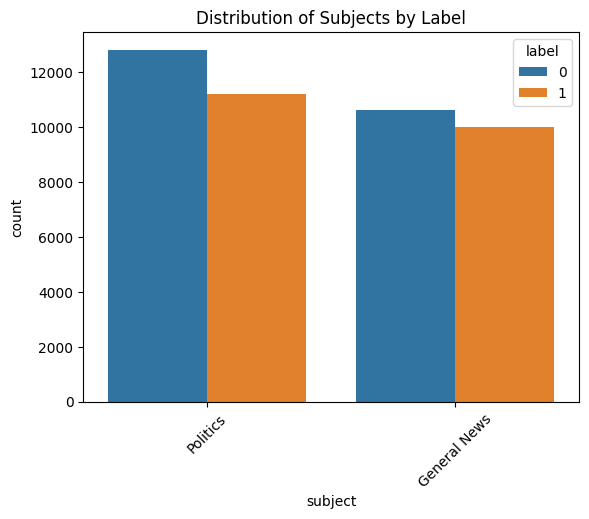

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot subject distribution
sns.countplot(x='subject', hue='label', data=combined_df)
plt.xticks(rotation=45)
plt.title("Distribution of Subjects by Label")
plt.show()


As we can see, there is no real difference between the subjects for true or fake news. We can conclude that subject is not a meaningful predictor for our task. So to avoid noise, we will delete the 'subject' column and delete combined_df

In [19]:
fake_df = fake_df.drop(columns=['subject'])
true_df = true_df.drop(columns=['subject'])
fake_df = fake_df.drop(columns=['label'])
true_df = true_df.drop(columns=['label'])
del combined_df

### **2.3.4 Fusing datasets**

We add labels before combining to two datasets into one.

In [20]:
true_df['label'] = 1  # 1 for true news
fake_df['label'] = 0  # 0 for fake news

df = pd.concat([true_df, fake_df], ignore_index=True)
print(df.head())
df['text'] = df['text'].str.split().str.join(' ')

                                               title  \
0  as us budget fight looms republicans flip thei...   
1  us military to accept transgender recruits on ...   
2  senior us republican senator let mr mueller do...   
3  fbi russia probe helped by australian diplomat...   
4  trump wants postal service to charge much more...   

                                                text       date  \
0  the head of a conservative republican faction ... 2017-12-31   
1  transgender people will be allowed for the fir... 2017-12-29   
2  the special counsel investigation of links bet... 2017-12-31   
3  trump campaign adviser george papadopoulos tol... 2017-12-30   
4  president donald trump called on the us postal... 2017-12-29   

   uppercase_percentage  label  
0              6.250000      1  
1              6.250000      1  
2             11.666667      1  
3             13.559322      1  
4              5.797101      1  


## **2.4 Exploratory Data Analysis (EDA)**

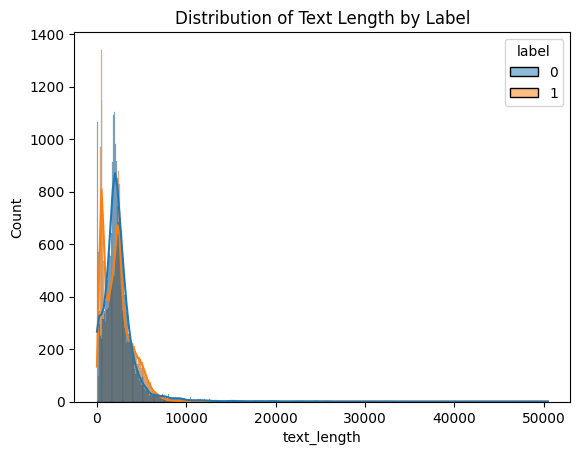

In [21]:
# Example: Distribution of text lengths
df['text_length'] = df['text'].apply(len)
sns.histplot(data=df, x='text_length', hue='label', kde=True)
plt.title('Distribution of Text Length by Label')
plt.show()

In [22]:
# Visualize a sample of the dataset
df.sample(10)

,title,text,date,uppercase_percentage,label,text_length
30501,just in why anchor mattlauer was just fired af...,nbc was in cover your ass mode with their long...,2017-11-29,26.315789,0,1832
42697,breaking it turns out bowe and bo have somethi...,besides being a muslim terrorist sympathizer i...,2015-07-24,71.621622,0,1806
20542,pakistans anticorruption agency starts crimina...,pakistan s anticorruption agency will open a c...,2017-09-07,3.260870,1,1459
8925,milestones in legal fight over texas abortion law,the us supreme court is set to rule on monday ...,2016-06-26,4.081633,1,3483
40815,wow liberal election fraud expert trump landsl...,,2016-11-10,34.782609,0,0
42372,heres the list of people we elected who just m...,if you re like us you either made a donation k...,2015-12-19,25.833333,0,1651
6685,trumps tough trade talk makes us firms fear ch...,us presidentelect donald trumps challenges to ...,2016-12-12,6.250000,1,4548
26336,noam chomsky begs americans to elect clinton a...,worldrenowned political theorist and activist ...,2016-08-09,25.000000,0,2520
4043,us says strategy on north korea centers on san...,us president donald trumps strategy on north k...,2017-04-26,5.797101,1,1256
43215,tillerson to north korea we are not your enemy...,21st century wire says while everyone is busy ...,2017-08-02,17.045455,0,3463


In [23]:
# Statistics
print(true_df.describe())
print()
print(fake_df.describe())

                                date  uppercase_percentage    label
count                          21211          21211.000000  21211.0
mean   2017-06-02 21:00:01.527509248              5.529878      1.0
min              2016-01-13 00:00:00              1.052632      1.0
25%              2017-01-27 00:00:00              3.448276      1.0
50%              2017-09-12 00:00:00              5.084746      1.0
75%              2017-11-02 00:00:00              7.017544      1.0
max              2017-12-31 00:00:00             26.415094      1.0
std                              NaN              2.771910      0.0

                                date  uppercase_percentage    label
count                          23433          23433.000000  23433.0
mean   2016-10-07 05:42:54.062220032             29.513559      0.0
min              2015-03-31 00:00:00              3.370787      0.0
25%              2016-04-06 00:00:00             19.827586      0.0
50%              2016-10-14 00:00:00           

The number of true and false articles is pretty even (47,7% - 52,3%), it's good for a binary classification.

In [24]:
# Analyse the length of
print(true_df['title'].apply(len).describe())
print()
print(fake_df['title'].apply(len).describe())
print()
print()
print(true_df['text'].apply(len).describe())
print()
print(fake_df['text'].apply(len).describe())

count    21211.000000
mean        63.066098
std          8.923350
min         26.000000
25%         57.000000
50%         63.000000
75%         68.000000
max        129.000000
Name: title, dtype: float64

count    23433.000000
mean        90.417744
std         26.234171
min         14.000000
25%         74.000000
50%         86.000000
75%        101.000000
max        270.000000
Name: title, dtype: float64


count    21211.000000
mean      2298.412852
std       1640.855036
min          0.000000
25%        863.500000
50%       2142.000000
75%       3126.000000
max      28997.000000
Name: text, dtype: float64

count    23433.000000
mean      2489.490462
std       2475.971621
min          0.000000
25%       1400.000000
50%       2116.000000
75%       2959.000000
max      50790.000000
Name: text, dtype: float64


In [25]:
empty_text_df = df[df['text'].str.len() == 0]
empty_text_count = df[df['text'].str.len() == 0].shape[0]
print(empty_text_count)

631
